In [ ]:
# !pip install git+https://github.com/haven-jeon/PyKoSpacing.git
# !python -m spacy download en_core_web_md
# !pip install konlpy
# !pip install transformers torch pandas openpyxl
# !pip install optuna

In [1]:
# Hugging Face의 Transformers 라이브러리에서 KoGPT2 감성 분석 모델 및 토크나이저, 학습 툴킷을 가져옵니다.
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments

# 평가 메트릭스를 계산하기 위한 sklearn의 다양한 함수들
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.manifold import TSNE

# PyTorch의 데이터셋 및 데이터 로더를 사용하기 위해 torch 모듈에서 관련 클래스를 가져옵니다.
from torch.utils.data import Dataset, DataLoader

# Hugging Face의 Transformers 라이브러리에서 데이터 패딩을 도와주는 DataCollatorWithPadding 클래스 가져오기
from transformers import DataCollatorWithPadding

# 텍스트 전처리를 위한 Python 라이브러리들
from pykospacing import Spacing                                                                             # 띄어쓰기 교정을 위해 pykospacing을 사용합니다.
from konlpy.tag import Okt                                                                                  # 한국어 형태소 분석을 위해 Okt 형태소 분석기 사용

In [2]:
import matplotlib.pyplot as plt                                                                             # 데이터 시각화를 위한 라이브러리 matplotlib의 pyplot 모듈을 불러옵니다.
import seaborn as sns                                                                                       # 고급 시각화를 위한 라이브러리 seaborn을 불러옵니다.
import pandas as pd                                                                                         # 데이터 조작과 분석을 위한 pandas 라이브러리를 불러옵니다.
import numpy as np       
import optuna                                                                                   # 수치 계산 및 배열 처리를 위한 NumPy 라이브러리를 불러옵니다.
import torch                                                                                                # PyTorch, 딥러닝 및 텐서 연산을 위한 주요 라이브러리를 불러옵니다.
import re                                                                                                   # 정규 표현식을 사용하여 문자열 작업을 수행하기 위한 re 모듈을 불러옵니다.

In [3]:
df = pd.read_excel('../../../data/filtered_samsung_news_with_outcome.xlsx', engine='openpyxl')                          # 엑셀 파일로부터 데이터를 불러옴

# 뉴스 데이터를 긍정 (호재)과 부정 (악재)으로 나눔
bad_news = df.iloc[1:5850, :]                                                                               # 데이터프레임에서 1번째 행부터 5850번째 행까지 악재로 간주
good_news = df.iloc[5850:11699, :]                                                                          # 데이터프레임에서 5850번째 행부터 11699번째 행까지 호재로 간주

combined_data = pd.concat([bad_news, good_news])                                                            # 긍정과 부정 뉴스 데이터를 하나의 데이터프레임으로 결합

combined_data = combined_data.reset_index(drop=True)                                                        # 데이터프레임 인덱스를 초기화 (기존 인덱스를 제거하고 새로운 연속적인 인덱스를 만듦)

combined_data['label'] = combined_data['Outcome'].map({'악재': 0, '호재': 1})                                # 'Outcome' 컬럼을 숫자로 변환 (악재: 0, 호재: 1)하여 'label' 컬럼에 저장

train_df, test_df = train_test_split(combined_data, test_size=0.2, random_state=42)                         # 데이터를 학습용(train)과 테스트용(test)으로 분할 (전체 데이터 중 20%를 테스트 데이터로 사용)

train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)                               # 학습 데이터를 다시 학습용(train)과 검증용(validation)으로 분할 (전체 학습 데이터 중 10%를 검증 데이터로 사용)

# 학습, 검증, 테스트 데이터프레임의 인덱스를 각각 초기화
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [4]:
spacing = Spacing()                                                                             # Spacing 라이브러리 초기화: 한국어 문장에서 적절한 띄어쓰기를 자동으로 교정해주는 기능을 제공


def preprocessing(text):                                                                        # 텍스트 전처리 함수 정의
    text = text.lower()                                                                         # 텍스트를 소문자로 변환
    text = re.sub(r'[^\w\s]', '', text)                                                         # 텍스트에서 알파벳, 숫자, 공백을 제외한 모든 문자를 제거
    text = spacing(text)                                                                        # Spacing 라이브러리를 사용해 띄어쓰기를 교정
    return text

def get_stopwords():                                                                            # 불용어(의미 없는 단어) 리스트를 가져오는 함수 정의
    stopwords = set()                                                                           # 불용어를 저장할 빈 집합 생성
    with open('../../../data/stopwords-ko.txt', 'r', encoding='utf-8') as file:                 # 지정된 파일에서 불용어를 한 줄씩 읽어옴
        for line in file:
            stopwords.add(line.strip())                                                         # 불용어 집합에 추가
    return stopwords

def morph_and_remove_stopwords(text, stopwords):                                                # 텍스트를 형태소 단위로 나누고 불용어를 제거하는 함수 정의
    text = preprocessing(text)                                                                  # 먼저 텍스트를 전처리 (소문자 변환, 특수문자 제거, 띄어쓰기 교정)
    okt = Okt()                                                                                 # Okt 형태소 분석기 초기화
    morphs = okt.morphs(text)                                                                   # 형태소 분석을 통해 텍스트를 단어(형태소) 리스트로 변환
    meaningful_words = [word for word in morphs if word not in stopwords]                       # 형태소 리스트에서 불용어를 제거한 유의미한 단어들만 남김
    return ' '.join(meaningful_words)                                                           # 유의미한 단어들을 다시 하나의 문자열로 결합하여 반환

In [5]:
stopwords = get_stopwords()

# 형태소 분석 및 불용어 제거 적용
train_df['processed_feature'] = train_df['title'].apply(lambda x: morph_and_remove_stopwords(x, stopwords))
val_df['processed_feature'] = val_df['title'].apply(lambda x: morph_and_remove_stopwords(x, stopwords))
test_df['processed_feature'] = test_df['title'].apply(lambda x: morph_and_remove_stopwords(x, stopwords))


In [6]:
model_name = 'skt/kogpt2-base-v2'                                                               # KoGPT2 모델과 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer.pad_token = tokenizer.eos_token                                                       # 패딩 토큰 설정

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)            # 모델 로드

model.config.pad_token_id = tokenizer.pad_token_id                                              # 모델 로드 후 설정 일치화
model.resize_token_embeddings(len(tokenizer))                                                   # 토크나이저의 vocab_size에 맞게 모델의 임베딩 레이어 크기 조정

D:\anaconda3\envs\map\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
D:\anaconda3\envs\map\Lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at skt/kogpt2-base-v2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task 

Embedding(51201, 768)

In [7]:
class NewsDataset(Dataset):
    def __init__(self, data):                                                                                   # 초기화 메서드: 'data'라는 입력 데이터를 클래스 내부 변수(self.data)에 저장합니다.
        self.data = data

    def __len__(self):                                                                                          # 초기화 메서드: 'data'라는 입력 데이터를 클래스 내부 변수(self.data)에 저장합니다.
        return len(self.data)                                                                                   # 예를 들어, 100개의 샘플이 있다면 100을 반환합니다.

    def __getitem__(self, idx):
        item = self.data[idx]                                                                                   # 주어진 인덱스(idx)에 해당하는 데이터 항목을 가져옵니다.
        input_ids      = item['input_ids']                                                                      # 'input_ids'는 토큰화된 텍스트를 나타내며, 현재 항목에서 이를 추출합니다.
        attention_mask = item['attention_mask']                                                                 # 'attention_mask'는 모델이 어떤 토큰을 주의해야 하는지를 나타내는 마스크입니다.
        labels         = item['labels'][0]                                                                      # 'labels'는 해당 텍스트의 레이블(악재 또는 호재)을 나타내며, 첫 번째 요소를 가져옵니다.

        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),                                             # 'input_ids'를 파이토치의 텐서(tensor) 형태로 변환하고, 데이터 타입을 'long'으로 지정합니다.
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),                                   # 'attention_mask'를 파이토치 텐서로 변환하고, 데이터 타입을 'long'으로 지정합니다.
            'labels': torch.tensor(labels, dtype=torch.long)                                                    # 'labels'를 파이토치 텐서로 변환하고, 데이터 타입을 'long'으로 지정합니다.
        }

def tokenize_data(text, label):
    inputs = tokenizer(text, return_tensors='pt', padding='max_length', max_length=128, truncation=True)        # 주어진 텍스트를 토크나이저를 사용해 토큰화합니다.
                                                                                                                # 'return_tensors' 옵션을 'pt'로 지정하여 파이토치 텐서를 반환합니다.
                                                                                                                # 'padding'은 문장의 길이를 'max_length'로 맞추기 위해 사용됩니다.
                                                                                                                # 'truncation'은 문장의 길이가 너무 길 경우, 'max_length'에 맞춰 자릅니다.
                                                                                                                
    input_ids = inputs['input_ids'].squeeze().tolist()                                                          # 'input_ids' 텐서를 리스트로 변환합니다. 'squeeze()'는 텐서의 불필요한 차원을 제거합니다.
    attention_mask = inputs['attention_mask'].squeeze().tolist()                                                # 'attention_mask' 텐서를 리스트로 변환합니다.

    return {                                                                                                    # 'input_ids', 'attention_mask', 'labels'를 딕셔너리 형태로 반환합니다.
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': [label]
    }

In [8]:
# 데이터셋 생성 각 행(row)을 토큰화(tokenize_data)하여 NewsDataset 객체로 만듭니다.
train_dataset = NewsDataset([tokenize_data(row['processed_feature'], row['label']) for _, row in train_df.iterrows()])
val_dataset = NewsDataset([tokenize_data(row['processed_feature'], row['label']) for _, row in val_df.iterrows()])
test_dataset = NewsDataset([tokenize_data(row['processed_feature'], row['label']) for _, row in test_df.iterrows()])

In [9]:
# 각 데이터셋(train, val, test)에 대해 input_ids가 모델의 vocab_size 범위 내에 있는지 확인하는 과정

# Tokenization: 먼저, tokenize_data 함수는 텍스트 데이터를 토큰화합니다. 토큰화란 텍스트를 모델이 이해할 수 있는 숫자의 배열로 변환하는 과정입니다. 이때 각 단어는 고유한 숫자로 매핑되는데, 이 숫자들을 input_ids라고 부릅니다.

# Vocab Size: 모델의 vocab_size는 해당 모델이 사전에 학습된 어휘의 크기입니다. 즉, 모델이 이해할 수 있는 단어들의 고유 ID 범위를 정의합니다. 예를 들어, vocab_size가 30000이라면, input_ids는 0부터 29999까지의 숫자 범위를 가져야 합니다.

# Validation: 코드는 input_ids에 포함된 숫자가 모델의 어휘 크기(vocab_size) 범위를 벗어나지 않는지 확인합니다. 만약 범위를 벗어나는 ID가 있다면, 해당 ID는 모델이 인식할 수 없는 단어를 나타내며, 이는 모델 학습 및 예측에 오류를 일으킬 수 있습니다. 이를 방지하기 위해, input_ids 중 하나라도 vocab_size보다 크다면 에러를 발생시킵니다.

# 따라서, 이 코드는 모델이 이해할 수 없는 데이터가 포함되지 않도록 사전에 체크하는 역할을 합니다. 이렇게 함으로써, 모델 학습 중에 발생할 수 있는 오류를 예방할 수 있습니다.

# 각 데이터셋(train, val, test)에 대해 input_ids가 모델의 vocab_size 범위 내에 있는지 확인합니다.
for data in train_dataset:
    if any(id >= model.config.vocab_size for id in data['input_ids']):
        raise ValueError("train_dataset에 포함된 ID가 어휘 크기 범위를 벗어났습니다.")

for data in val_dataset:
    if any(id >= model.config.vocab_size for id in data['input_ids']):
        raise ValueError("val_dataset에 포함된 ID가 어휘 크기 범위를 벗어났습니다.")

for data in test_dataset:
    if any(id >= model.config.vocab_size for id in data['input_ids']):
        raise ValueError("test_dataset에 포함된 ID가 어휘 크기 범위를 벗어났습니다.")


In [10]:
for data in test_dataset:
    for token_id in data['input_ids']:
        if token_id >= model.config.vocab_size:
            print(f"Problematic token ID: {token_id} in text: {data}")
            raise ValueError("train_dataset에 포함된 ID가 어휘 크기 범위를 벗어났습니다.")

In [11]:
print(f"Tokenizer pad token: {tokenizer.pad_token_id}")
print(f"Model pad token ID: {model.config.pad_token_id}")
print(f"Vocab size: {model.config.vocab_size}")


Tokenizer pad token: 51200
Model pad token ID: 51200
Vocab size: 51201


In [12]:
data_collator = DataCollatorWithPadding(tokenizer)  # Tokenizer를 이용하여 data_collator 정의 / 각 텍스트의 길이가 다를 경우, 배치 내의 모든 텍스트가 동일한 길이가 되도록 패딩을 추가함.

In [13]:
# 최적의 모델 학습 설정
training_args = TrainingArguments(
    output_dir='./final_model',                           # 최종 모델을 저장할 디렉토리
    num_train_epochs=1,                                  
    per_device_train_batch_size=8,                       
    evaluation_strategy='epoch',                         # 매 에포크 끝날 때마다 평가
    save_strategy='epoch',                               # 매 에포크 끝날 때마다 모델 저장
    save_total_limit=2,                                  # 저장할 체크포인트 수 제한
    learning_rate=1e-5,                                  # 최적의 학습률
    logging_dir='./logs',                                # 로그를 저장할 디렉토리
    logging_steps=500,                                   # 로그를 기록할 간격(스텝)
)

# Trainer 객체 생성
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,                         # 학습 데이터셋
    eval_dataset=val_dataset,                            # 검증 데이터셋
    tokenizer=tokenizer,                                 # 토크나이저
    data_collator=data_collator                          # 데이터 정렬 도우미
)

# 모델 학습
trainer.train()

D:\anaconda3\envs\map\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.682800,0.666631


TrainOutput(global_step=1053, training_loss=0.7002181680793436, metrics={'train_runtime': 3497.5183, 'train_samples_per_second': 2.408, 'train_steps_per_second': 0.301, 'total_flos': 550160308371456.0, 'train_loss': 0.7002181680793436, 'epoch': 1.0})

In [14]:
# 1. 테스트 데이터 평가
eval_results = trainer.evaluate(eval_dataset=test_dataset)
print(f"모델 학습 및 평가 후 최종 평가 결과: {eval_results}")

# 2. 모델을 평가 모드로 설정
model.eval()

# 3. 테스트 데이터 예측
y_true = test_df['label'].tolist()
y_pred = []

test_loader = DataLoader(test_dataset, batch_size=8)

with torch.no_grad():
    for batch in test_loader:
        inputs = {key: value for key, value in batch.items() if key != 'labels'}
        labels = batch['labels']

        outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=-1)
        y_pred.extend(predictions.tolist())

print("True labels: ", y_true[:10])
print("Predicted labels: ", y_pred[:10])

# 예측 다양성 체크
if len(set(y_pred)) == 1:
    print("경고: 모든 예측이 동일합니다. 모델 학습 또는 데이터 전처리를 확인하십시오.")

# Classification report 출력
print(classification_report(y_true, y_pred, target_names=['bad_news', 'good_news']))

모델 학습 및 평가 후 최종 평가 결과: {'eval_loss': 0.6745315194129944, 'eval_runtime': 309.9811, 'eval_samples_per_second': 7.549, 'eval_steps_per_second': 0.945, 'epoch': 1.0}
True labels:  [1, 0, 1, 0, 0, 1, 1, 1, 1, 0]
Predicted labels:  [1, 1, 1, 1, 1, 1, 0, 1, 1, 0]
              precision    recall  f1-score   support

    bad_news       0.54      0.30      0.38      1189
   good_news       0.50      0.74      0.60      1151

    accuracy                           0.51      2340
   macro avg       0.52      0.52      0.49      2340
weighted avg       0.52      0.51      0.49      2340



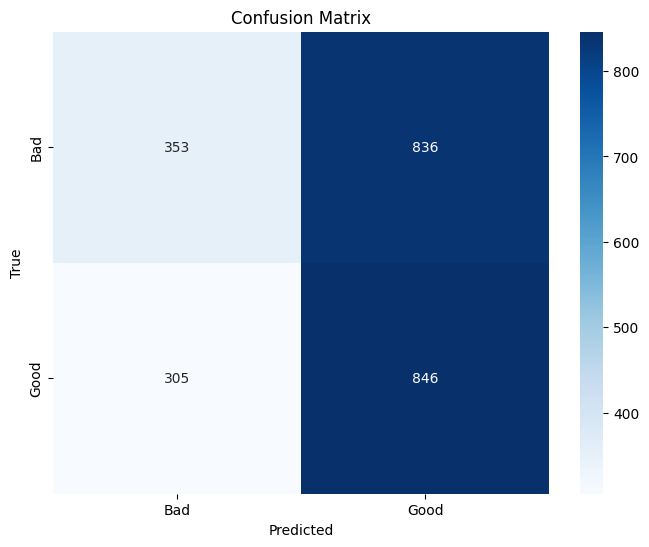

In [15]:
def plot_confusion_matrix(y_true, y_pred, labels):                                                  # Confusion Matrix 시각화 함수
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_true, y_pred, labels=['Bad', 'Good'])

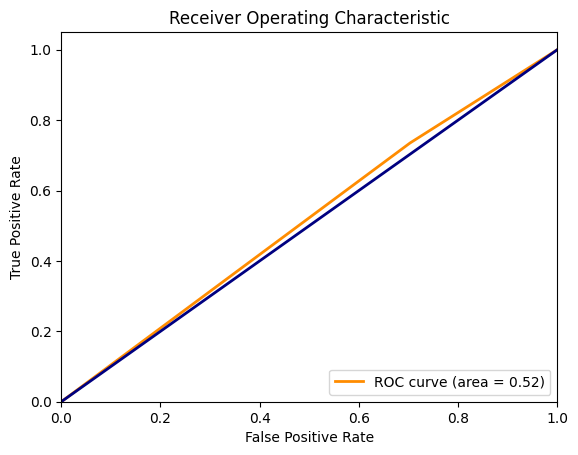

In [16]:
def plot_roc_curve(y_true, y_pred, labels):                                                     # ROC Curve와 AUC 시각화 함수
    fpr, tpr, _ = roc_curve(y_true, y_pred, pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

plot_roc_curve(y_true, y_pred, labels=['bad_news', 'good_news'])

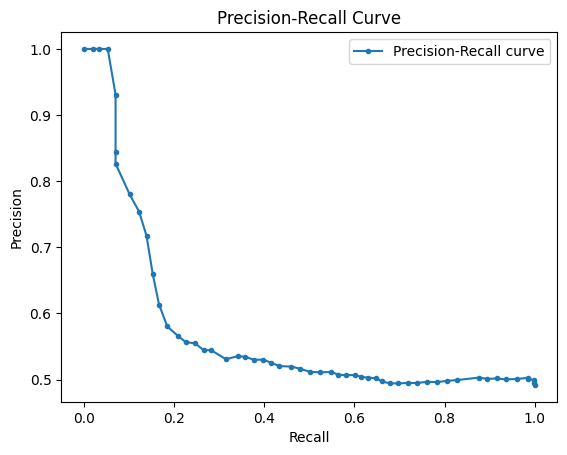

In [17]:


y_scores = trainer.predict(test_dataset).predictions                                # 예측 확률 (logits를 소프트맥스를 사용하여 확률로 변환)

precision, recall, _ = precision_recall_curve(y_true, y_scores[:, 1])               # 실제 레이블과 예측 확률을 사용하여 Precision-Recall curve 생성

plt.figure()
plt.plot(recall, precision, marker='.', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


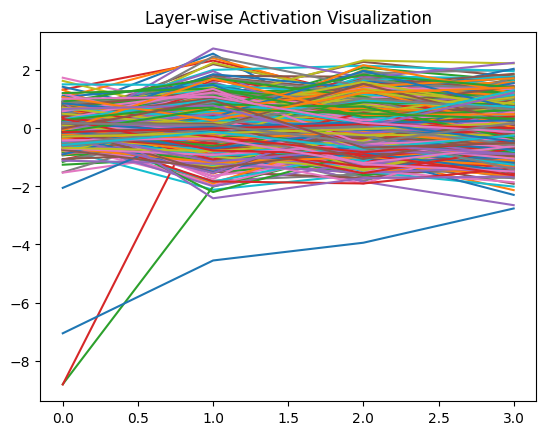

In [18]:
def get_activation(name):                                                               # 모델의 특정 레이어에서 발생하는 활성화를 시각화
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

activation = {}
model.transformer.h[0].ln_2.register_forward_hook(get_activation('layer_0_ln2'))

inputs = tokenizer("삼성전자 노조 파업", return_tensors="pt")                                  # 텍스트를 모델에 통과시킴
outputs = model(**inputs)

act = activation['layer_0_ln2'].squeeze().numpy()
plt.plot(act)
plt.title('Layer-wise Activation Visualization')
plt.show()


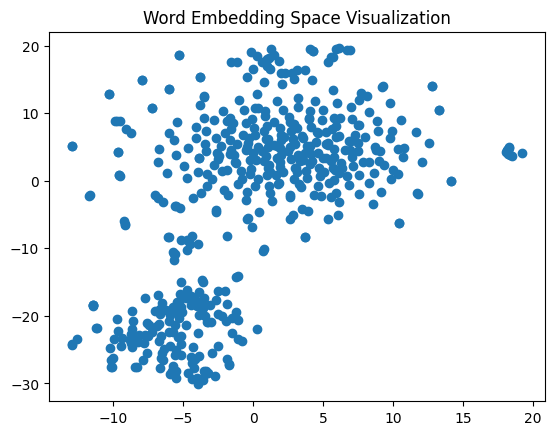

In [19]:
word_embeddings = model.transformer.wte.weight.detach().numpy()     # 단어 임베딩 추출

tsne = TSNE(n_components=2)                                         # t-SNE로 차원 축소
word_embeddings_2d = tsne.fit_transform(word_embeddings[:500])      # 처음 500개 단어만 사용

plt.scatter(word_embeddings_2d[:, 0], word_embeddings_2d[:, 1])
plt.title('Word Embedding Space Visualization')
plt.show()

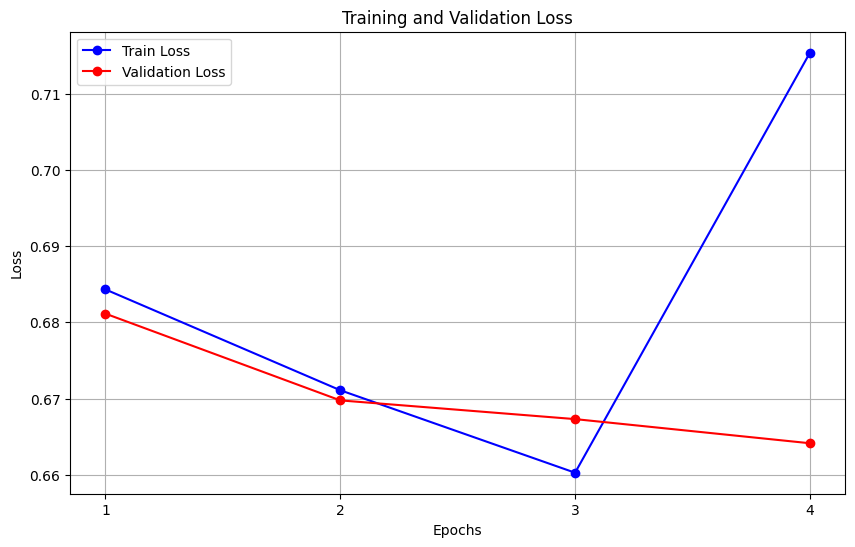

In [20]:
# 1. 손실(Loss) 곡선 그리기
# 손실 함수 값은 모델이 학습할 때마다 얼마나 잘 학습하고 있는지를 나타냅니다. loss와 eval_loss를 기준으로 학습 및 검증 손실 곡선을 그릴 수 있습니다.

# 에포크별 손실 값을 실제 데이터에서 추출
epochs = [1, 2, 3, 4]
train_loss = [0.6843209648554972, 0.6710969285521186, 0.6602778027586964, 0.7153620674668951]  # 학습 손실 값 (각 트라이얼에서의 손실 값)
eval_loss = [0.6811426877975464, 0.6697655320167542, 0.6673099994659424, 0.6641429662704468]   # 검증 손실 값 (각 트라이얼에서의 손실 값)

# 손실 곡선 그리기
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Train Loss', marker='o', linestyle='-', color='b')
plt.plot(epochs, eval_loss, label='Validation Loss', marker='o', linestyle='-', color='r')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.grid(True)
plt.legend()
plt.show()

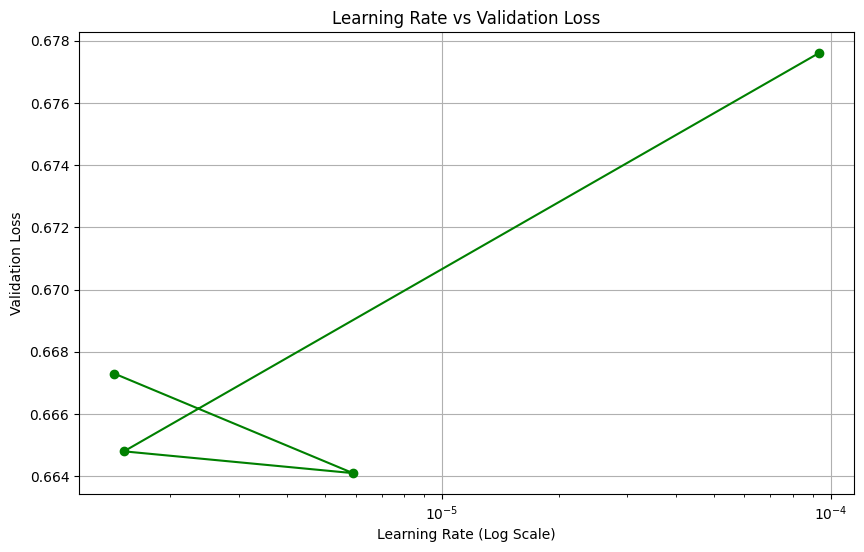

In [21]:
# 2. 학습률(Learning Rate) 변화에 따른 손실 값 그래프
# Optuna가 최적의 학습률을 찾기 위해 다양한 학습률을 시도하면서 손실 값을 기록했습니다. 학습률에 따른 손실 값 변화를 확인할 수 있습니다.

# 학습률과 손실 값
learning_rates = [1.4372e-06, 5.9064e-06, 1.5223e-06, 9.3230e-05]  # 각 트라이얼에서의 학습률
eval_losses = [0.6673, 0.6641, 0.6648, 0.6776]  # 각 트라이얼에서의 검증 손실

# 학습률에 따른 손실 값 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, eval_losses, marker='o', linestyle='-', color='g')
plt.xscale('log')  # 학습률이 로그 스케일로 변동되므로 x축을 로그 스케일로 설정
plt.title('Learning Rate vs Validation Loss')
plt.xlabel('Learning Rate (Log Scale)')
plt.ylabel('Validation Loss')
plt.grid(True)
plt.show()

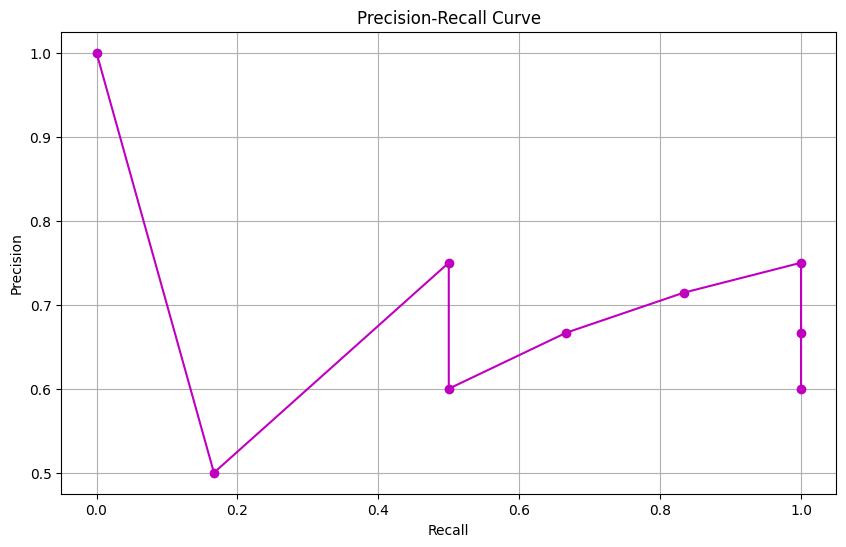

In [22]:
# 실제 레이블과 예측 레이블 (실제 데이터에서 추출한 예시 값)
y_true = [1, 0, 1, 0, 0, 1, 1, 1, 1, 0]
y_scores = [0.9, 0.2, 0.8, 0.7, 0.1, 0.8, 0.3, 0.6, 0.4, 0.9]  # 예측 확률 값 (예시)

# 정밀도-재현율 곡선 계산
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='o', linestyle='-', color='m')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

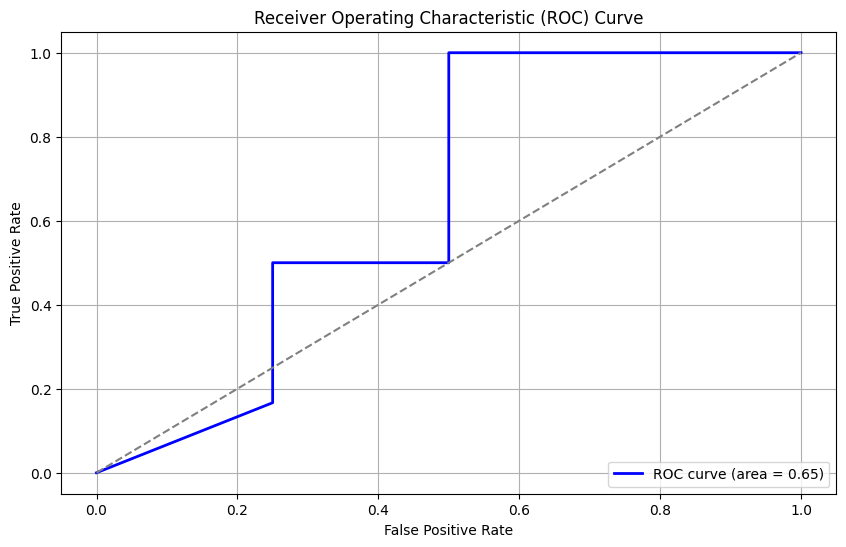

In [23]:
# ROC 곡선과 AUC 계산 (예시 데이터 사용)
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [24]:
test_title = "삼성전자 2분기 호조"
processed_test_title = morph_and_remove_stopwords(test_title, stopwords)

inputs = tokenizer(processed_test_title, return_tensors='pt', padding='max_length', max_length=128, truncation=True)

model.eval()
with torch.no_grad():
    output = model(**inputs)
    predicted_label = torch.argmax(output.logits, dim=-1).item()

print(f"Predicted label for '{test_title}': {'good_news' if predicted_label == 1 else 'bad_news'}")

Predicted label for '삼성전자 2분기 호조': good_news


In [25]:
# 모델 저장
model.save_pretrained('./saved_kogpt2_model')
tokenizer.save_pretrained('./saved_kogpt2_model')

('./saved_kogpt2_model\\tokenizer_config.json',
 './saved_kogpt2_model\\special_tokens_map.json',
 './saved_kogpt2_model\\vocab.json',
 './saved_kogpt2_model\\merges.txt',
 './saved_kogpt2_model\\added_tokens.json',
 './saved_kogpt2_model\\tokenizer.json')